<a href="https://colab.research.google.com/github/morganFitzg/fashion_annotation/blob/main/Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import random
from PIL import Image
import io
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMaterialist

In [3]:
with open('/content/drive/My Drive/fashion_annotation/train.json') as f:
    data=f.read()
imat=json.loads(data)
imat.keys()

dict_keys(['info', 'images', 'annotations', 'license'])

In [4]:
imat_images=imat['images']

In [5]:
imat_images_df=pd.DataFrame(imat_images)

In [6]:
imat_images[:10]

[{'imageId': '1',
  'url': 'https://contestimg.wish.com/api/webimage/570f35feb2f4b95d223aa9b1-large'},
 {'imageId': '2',
  'url': 'https://contestimg.wish.com/api/webimage/5468f1c0d96b290ff8e5c805-large'},
 {'imageId': '3',
  'url': 'https://contestimg.wish.com/api/webimage/546410237d57f323e72ca414-large'},
 {'imageId': '4',
  'url': 'https://contestimg.wish.com/api/webimage/550b955fdd699c1a0351f84e-large'},
 {'imageId': '5',
  'url': 'https://contestimg.wish.com/api/webimage/54451f33355b4e0fd3028a30-large'},
 {'imageId': '6',
  'url': 'https://contestimg.wish.com/api/webimage/571e0b1cea3cc75d8a004f37-large'},
 {'imageId': '7',
  'url': 'https://contestimg.wish.com/api/webimage/52cbee3f34067e3d742181de-large'},
 {'imageId': '8',
  'url': 'https://contestimg.wish.com/api/webimage/53994b413060c60cb1df5dfb-large'},
 {'imageId': '9',
  'url': 'https://contestimg.wish.com/api/webimage/567179ed74c8b6615676e022-large'},
 {'imageId': '10',
  'url': 'https://contestimg.wish.com/api/webimage/562

In [7]:
imat_images_df.head()

,url,imageId
0,https://contestimg.wish.com/api/webimage/570f3...,1
1,https://contestimg.wish.com/api/webimage/5468f...,2
2,https://contestimg.wish.com/api/webimage/54641...,3
3,https://contestimg.wish.com/api/webimage/550b9...,4
4,https://contestimg.wish.com/api/webimage/54451...,5


In [8]:
df=pd.read_csv('/content/drive/My Drive/fashion_annotation/iMat_fashion_2018_label_map_228.csv')
df.head()

,labelId,taskId,labelName,taskName
0,1,6,Argyle,pattern
1,2,9,Asymmetric,style
2,3,1,Athletic Pants,category
3,4,1,Athletic Sets,category
4,5,1,Athletic Shirts,category


In [9]:
test1=imat['annotations'][0]['labelId']
test1=[int(x) for x in test1]
names=[df.loc[x-1,'labelName'] for x in test1]
names

['Jumpsuits Overalls & Rompers', 'Female', 'Polyester', 'Floral', 'Bodycon']

In [10]:
test1=imat['annotations'][1]['labelId']
test1=[int(x) for x in test1]
names=[df.loc[x-1,'labelName'] for x in test1]
names

['Casual Dresses', 'Female', 'Chiffon', 'V-Necks', 'Long Sleeved', 'Pleated']

In [11]:
#create dictionary of unique labels for each task
tasks=df['taskName'].unique()
task_labels={}

for t in tasks:

    labels=df[df['taskName']==t]['labelName'].to_list()
    task_labels[t]=labels

In [12]:
df.groupby('taskName').mean()['taskId']

taskName
category    1.0
color       2.0
gender      3.0
material    4.0
neckline    5.0
pattern     6.0
sleeve      8.0
style       9.0
Name: taskId, dtype: float64

In [13]:
imat_test=imat['annotations'][:10]
list_images=[]

for im in imat['annotations']:
    im_dict={'imageId':im['imageId'],
     'category': None,
     'color': None,
     'gender': None,
     'material': None,
     'neckline': None,
     'pattern': None,
     'sleeve': None,
     'style': None,
     }

    labs=im['labelId']
    labs=[int(l) for l in labs]
    names=[df.loc[x-1,'labelName'] for x in labs]

    for l in names:
        for t in tasks:
            if l in task_labels[t]:
                im_dict[t]=l
                break

    list_images.append(im_dict)
    
imat_df=pd.DataFrame(list_images)
imat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014544 entries, 0 to 1014543
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   imageId   1014544 non-null  object
 1   category  915281 non-null   object
 2   color     467488 non-null   object
 3   gender    1014544 non-null  object
 4   material  591692 non-null   object
 5   neckline  722800 non-null   object
 6   pattern   312137 non-null   object
 7   sleeve    734420 non-null   object
 8   style     611758 non-null   object
dtypes: object(9)
memory usage: 69.7+ MB


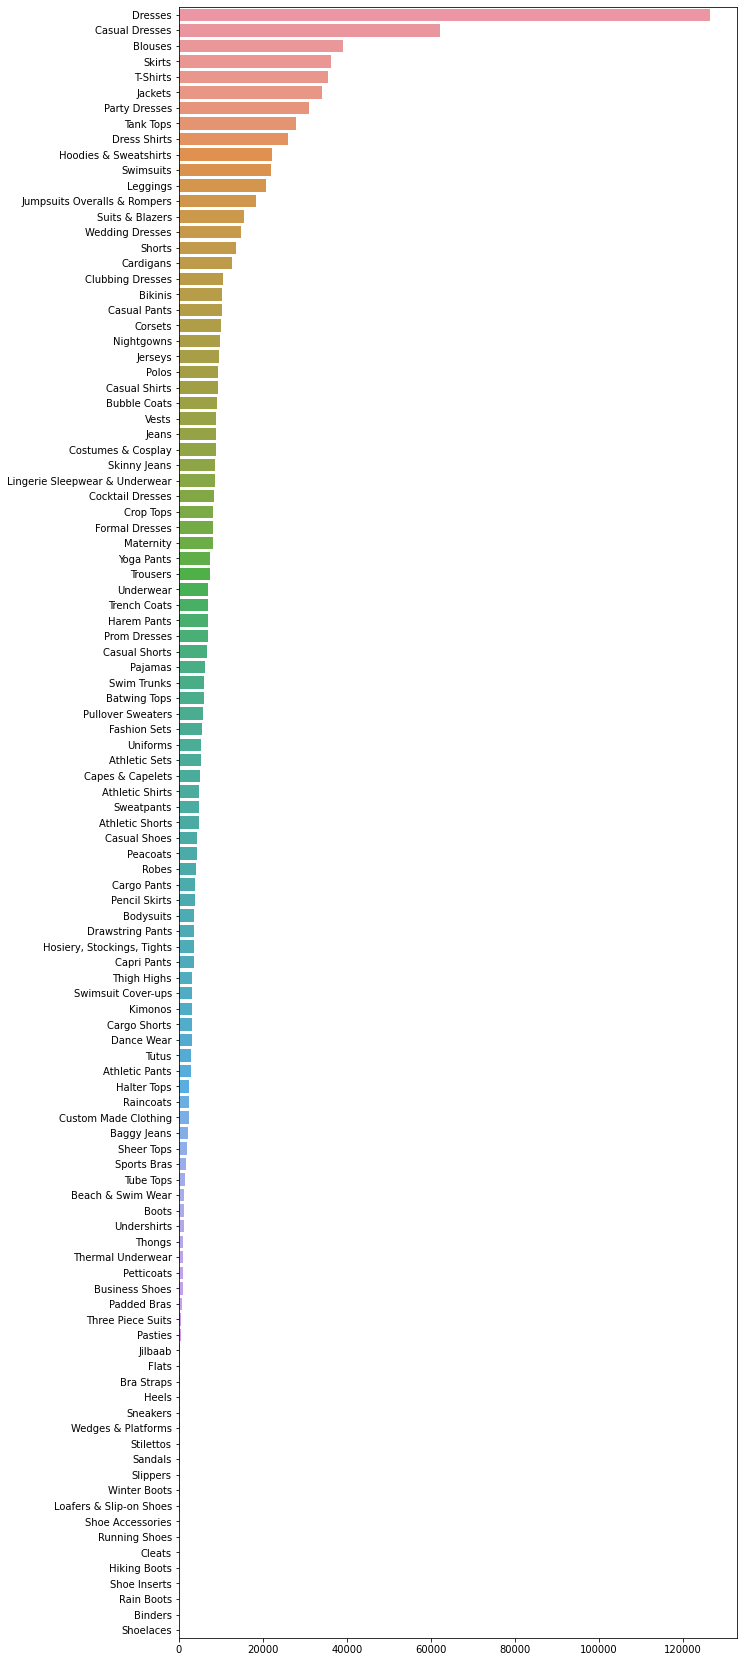

In [14]:
c=imat_df['category'].value_counts().sort_values(ascending=False)
fig,ax=plt.subplots(figsize=(10,30))
sns.barplot(x=c.values,y=c.index,orient='h',ax=ax)

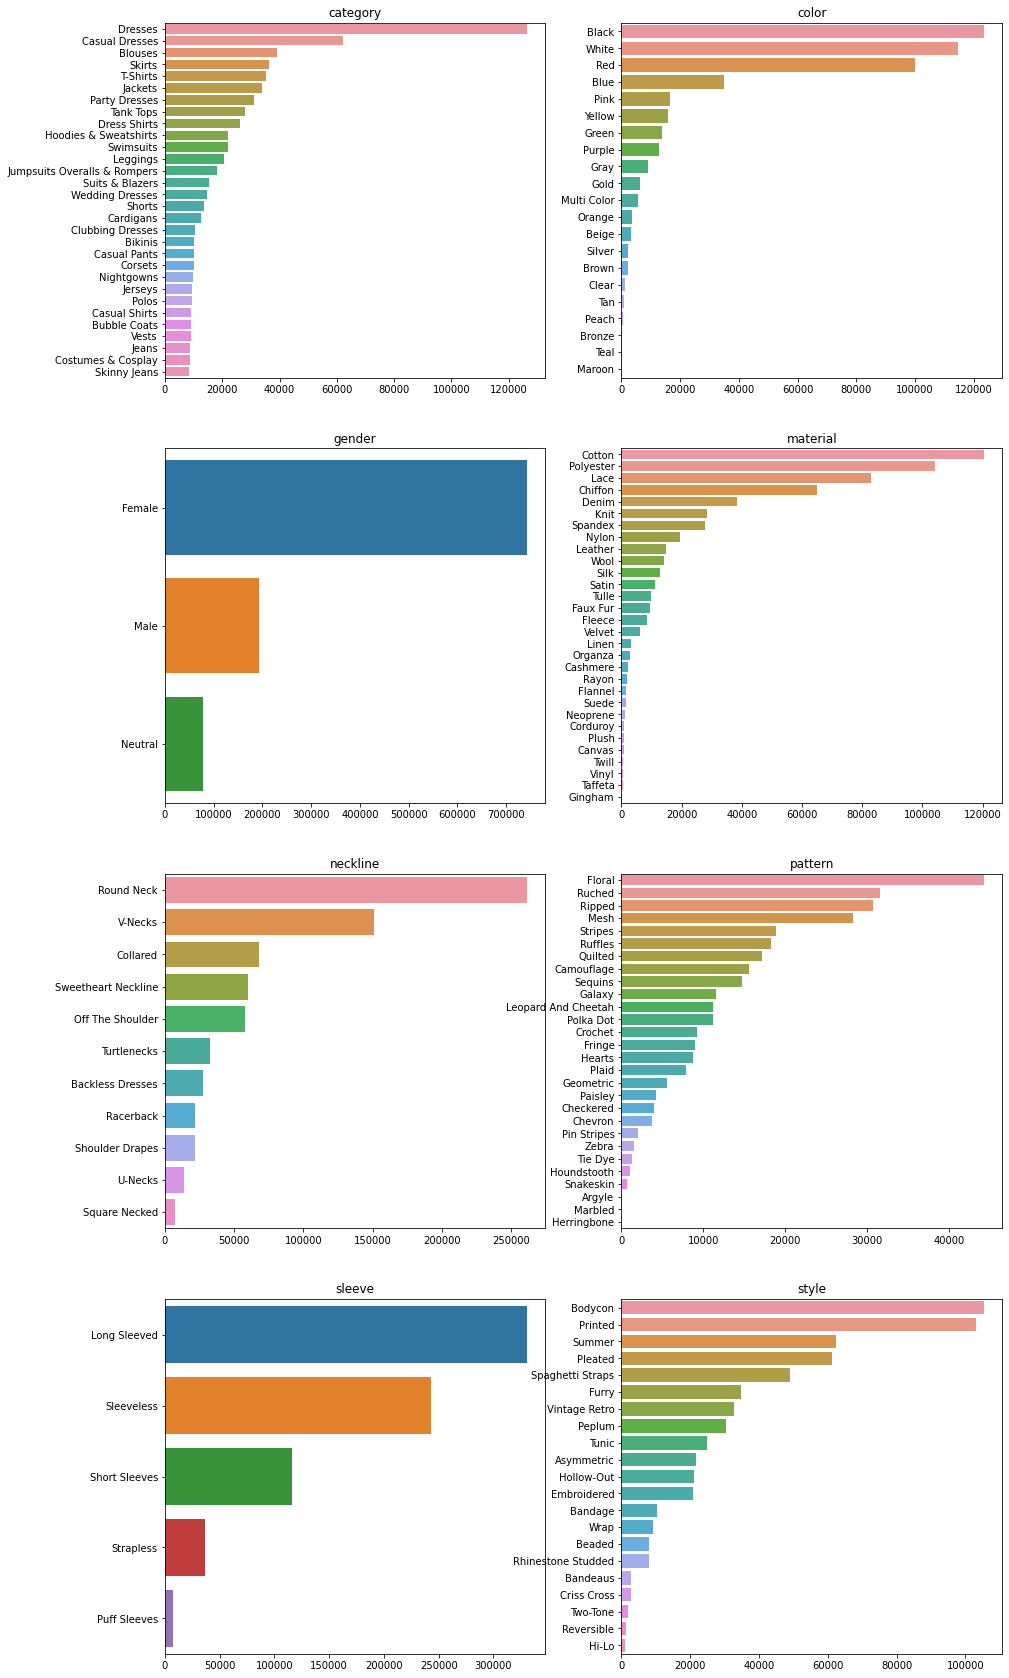

In [15]:
fig, axes = plt.subplots(4,2,figsize=(15,30))
cols=imat_df.columns[1:]

for count,ax in enumerate(axes.flatten()):
    counts=imat_df[cols[count]].value_counts().sort_values(ascending=False)
    if len(counts)>30:
        counts=counts[:30]
    sns.barplot(x=counts.values,y=counts.index,orient='h',ax=ax)
    ax.set_title(cols[count])

## Preview Different Categories

In [16]:
#write a function to preview random photos from selected category

def preview_photos(df,attr,label):
  images=[]
  label_im_ids=df[df[attr]==label]['imageId'].to_list()
  ids=random.sample(label_im_ids,3)
  print(ids)
  label_urls=[]
  for id in ids:
    url=imat_images_df[imat_images_df['imageId']==id].reset_index().at[0,'url']
    url=url[:4]+url[5:]
    label_urls.append(url)

  for link in label_urls:
    response=requests.get(link,stream=True)
    im=response.content
    img=Image.open(io.BytesIO(im))
    images.append(img)

  fig,axes=plt.subplots(1,3)
  for count,ax in enumerate(axes.flatten()):
    ax.imshow(images[count])
    ax.axis('off')

['293590', '909074', '339527']


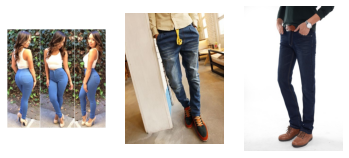

In [17]:
preview_photos(imat_df,'category','Jeans')

### Edit Category attribute

In [18]:
to_remove=['Shoelaces','Binders','Shoe Inserts','Cleats','Shoe Accessories','Bra Straps','Jilbaab','Pasties',
           'Thermal Underwear','Petticoats','Custom Made Clothing','Undershirts','Beach & Swim Wear',
           'Fashion Sets','Athletic Sets']

to_change={'Rain Boots':'Boots','Hiking Boots':'Boots','Running Shoes':'Sneakers','Loafers & Slip-on Shoes':'Flats',
           'Winter Boots':'Boots','Slippers':'Flats','Stilettos':'Heels','Three Piece Suits':'Suits & Blazers',
           'Padded Bras':'Lingerie Sleepwear & Underwear','Business Shoes':'Flats','Thongs':'Lingerie Sleepwear & Underwear',
           'Baggy Jeans':'Jeans','Raincoats':'Jackets','Cargo Shorts':'Shorts','Thigh Highs':'Hosiery, Stockings, Tights',
           'Pencil Skirts':'Skirts','Cargo Pants':'Casual Pants','Drawstring Pants':'Casual Pants','Peacoats':'Jackets',
           'Prom Dresses':'Formal Dresses','Cocktail Dresses':'Dresses','Bikinis':'Swimsuits','Party Dresses':'Dresses',
           'T-Shirts':'Casual Shirts','Yoga Pants':'Leggings','Skinny Jeans':'Jeans'}

In [19]:
imat_images_df.head()

,url,imageId
0,https://contestimg.wish.com/api/webimage/570f3...,1
1,https://contestimg.wish.com/api/webimage/5468f...,2
2,https://contestimg.wish.com/api/webimage/54641...,3
3,https://contestimg.wish.com/api/webimage/550b9...,4
4,https://contestimg.wish.com/api/webimage/54451...,5


In [20]:
imat_df.head(10)

,imageId,category,color,gender,material,neckline,pattern,sleeve,style
0,1,Jumpsuits Overalls & Rompers,None,Female,Polyester,None,Floral,None,Bodycon
1,2,Casual Dresses,None,Female,Chiffon,V-Necks,None,Long Sleeved,Pleated
2,3,Skirts,None,Female,Knit,Round Neck,None,Long Sleeved,Printed
3,4,Blouses,None,Female,Chiffon,Round Neck,None,Short Sleeves,None
4,5,Swimsuits,None,Female,Polyester,Round Neck,Stripes,Sleeveless,Printed
5,6,T-Shirts,None,Male,Cotton,Round Neck,None,Short Sleeves,Summer
6,7,Nightgowns,White,Neutral,Spandex,V-Necks,None,None,Hollow-Out
7,8,Blouses,Black,Female,Lace,Collared,Mesh,Long Sleeved,None
8,9,None,None,Female,Knit,Round Neck,Stripes,Long Sleeved,Vintage Retro
9,10,Jackets,None,Female,Denim,Collared,Ripped,Long Sleeved,Wrap


In [21]:
#update imat_df
#also make imat_numbers_df to recode 
#easier to update df while keeping track of which category being updated,
#then turn back into dictionary like image['annotations'] if needed

#remove images with unwanted labels (these are confusing or not applicable)
imat_df['remove']=imat_df['category'].apply(
    lambda x: True if x in to_remove else False
)
imat_df_rev1=imat_df[imat_df['remove']==False]
imat_df_rev1.drop(columns='remove',inplace=True)
imat_df_rev1.info()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 995439 entries, 0 to 1014543
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   imageId   995439 non-null  object
 1   category  896176 non-null  object
 2   color     459589 non-null  object
 3   gender    995439 non-null  object
 4   material  582979 non-null  object
 5   neckline  711384 non-null  object
 6   pattern   308418 non-null  object
 7   sleeve    721938 non-null  object
 8   style     604221 non-null  object
dtypes: object(9)
memory usage: 75.9+ MB


In [22]:
#map to_change to the category column
imat_df_rev1['category']=imat_df_rev1['category'].apply(
    lambda x: to_change[x] if x in to_change else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
imat_df_rev1.head(10)

,imageId,category,color,gender,material,neckline,pattern,sleeve,style
0,1,Jumpsuits Overalls & Rompers,None,Female,Polyester,None,Floral,None,Bodycon
1,2,Casual Dresses,None,Female,Chiffon,V-Necks,None,Long Sleeved,Pleated
2,3,Skirts,None,Female,Knit,Round Neck,None,Long Sleeved,Printed
3,4,Blouses,None,Female,Chiffon,Round Neck,None,Short Sleeves,None
4,5,Swimsuits,None,Female,Polyester,Round Neck,Stripes,Sleeveless,Printed
5,6,Casual Shirts,None,Male,Cotton,Round Neck,None,Short Sleeves,Summer
6,7,Nightgowns,White,Neutral,Spandex,V-Necks,None,None,Hollow-Out
7,8,Blouses,Black,Female,Lace,Collared,Mesh,Long Sleeved,None
8,9,None,None,Female,Knit,Round Neck,Stripes,Long Sleeved,Vintage Retro
9,10,Jackets,None,Female,Denim,Collared,Ripped,Long Sleeved,Wrap


### Edit Pattern attribute

In [24]:
#second attribute will be pattern...filter out where style is None
imat_df_rev2=imat_df_rev1.copy()
imat_df_rev2['pattern']=imat_df_rev2['pattern'].fillna('None')

['504221', '527199', '13700']


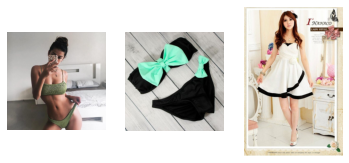

In [25]:
#sample from the pictures that don't have a pattern
preview_photos(imat_df_rev2,'pattern','None')

Many of the images with no pattern identified are solid color. For those without labels, keep the label 'None' to indicate solid color. Of note, the dataset is not labeled perfectly and there are some patterned clothes without labels.

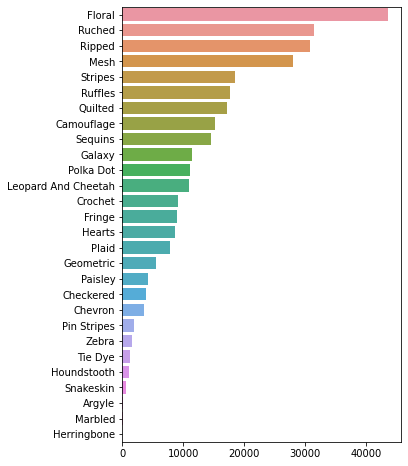

In [26]:
c=imat_df_rev1['pattern'].value_counts().sort_values(ascending=False)
fig,ax=plt.subplots(figsize=(5,8))
sns.barplot(x=c.values,y=c.index,orient='h',ax=ax)

['722940', '149100', '923437']


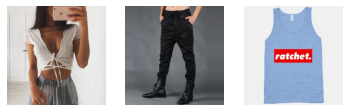

In [27]:
preview_photos(imat_df_rev2,'pattern','None')

In [28]:
to_remove_pat=['Galaxy','Fringe']
to_change_pat={'Ruched':'None','Marbled':'Tie Dye'}

In [29]:
#remove unwanted pattern labels and associated images
imat_df_rev2['remove']=imat_df_rev2['pattern'].apply(
    lambda x: True if x in to_remove_pat else False
)
imat_df_rev2=imat_df_rev2[imat_df_rev2['remove']==False]
imat_df_rev2.drop(columns='remove',inplace=True)
imat_df_rev2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975125 entries, 0 to 1014543
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   imageId   975125 non-null  object
 1   category  877524 non-null  object
 2   color     452678 non-null  object
 3   gender    975125 non-null  object
 4   material  570291 non-null  object
 5   neckline  697589 non-null  object
 6   pattern   975125 non-null  object
 7   sleeve    708242 non-null  object
 8   style     591575 non-null  object
dtypes: object(9)
memory usage: 74.4+ MB


In [30]:
#map to_change to the pattern column
imat_df_rev2['pattern']=imat_df_rev2['pattern'].apply(
    lambda x: to_change_pat[x] if x in to_change_pat else x)

## Finalize dataset output

In [31]:
imat_df_final=imat_df_rev2.drop(columns=['color','gender','material','neckline','sleeve','style'])
imat_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975125 entries, 0 to 1014543
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   imageId   975125 non-null  object
 1   category  877524 non-null  object
 2   pattern   975125 non-null  object
dtypes: object(3)
memory usage: 29.8+ MB


In [32]:
imat_df_final=imat_df_final[imat_df_final['category'].notnull()]
imat_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877524 entries, 0 to 1014543
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   imageId   877524 non-null  object
 1   category  877524 non-null  object
 2   pattern   877524 non-null  object
dtypes: object(3)
memory usage: 26.8+ MB


In [33]:
#make the label a tuple with (category, pattern)

def create_str_label(row):
  return (row['category'],row['pattern'])

imat_df_final['str_label']=imat_df_final.apply(create_str_label,axis=1)
imat_df_final.head()

,imageId,category,pattern,str_label
0,1,Jumpsuits Overalls & Rompers,Floral,"(Jumpsuits Overalls & Rompers, Floral)"
1,2,Casual Dresses,None,"(Casual Dresses, None)"
2,3,Skirts,None,"(Skirts, None)"
3,4,Blouses,None,"(Blouses, None)"
4,5,Swimsuits,Stripes,"(Swimsuits, Stripes)"


In [34]:
df.tail()

,labelId,taskId,labelName,taskName
223,224,4,Wool,material
224,225,9,Wrap,style
225,226,2,Yellow,color
226,227,1,Yoga Pants,category
227,228,6,Zebra,pattern


In [35]:
#make numeric label tuples
df.head()
#map label names to numbers
cat_df=df[df['taskName']=='category']
cat_list=list(zip(cat_df['labelName'].to_list(),cat_df['labelId'].to_list()))
cat_dict={x[0]:int(x[1]) for x in cat_list}

pat_df=df[df['taskName']=='pattern']
pat_list=list(zip(pat_df['labelName'].to_list(),pat_df['labelId'].to_list()))
#append label for None
pat_list.append(('None','229'))
pat_dict={x[0]:int(x[1]) for x in pat_list}

In [36]:
def create_num_label(row):
  tup=row['str_label']
  return (cat_dict[tup[0]],pat_dict[tup[1]])

imat_df_final['num_label']=imat_df_final.apply(create_num_label,axis=1)
imat_df_final.head()

,imageId,category,pattern,str_label,num_label
0,1,Jumpsuits Overalls & Rompers,Floral,"(Jumpsuits Overalls & Rompers, Floral)","(95, 70)"
1,2,Casual Dresses,None,"(Casual Dresses, None)","(36, 229)"
2,3,Skirts,None,"(Skirts, None)","(170, 229)"
3,4,Blouses,None,"(Blouses, None)","(18, 229)"
4,5,Swimsuits,Stripes,"(Swimsuits, Stripes)","(189, 181)"


In [37]:
imat_df_final.drop(columns=['category','pattern'],inplace=True)

In [51]:
#add column with url of image

#  url=imat_images_df[imat_images_df['imageId']==id].reset_index().at[0,'url']
 # url=url[:4]+url[5:]
imat_df_final['imageId']=imat_df_final['imageId'].astype(int)
final=imat_df_final.merge(imat_images_df,on='imageId')
final.head(5)

,imageId,str_label,num_label,url
0,1,"(Jumpsuits Overalls & Rompers, Floral)","(95, 70)",https://contestimg.wish.com/api/webimage/570f3...
1,2,"(Casual Dresses, None)","(36, 229)",https://contestimg.wish.com/api/webimage/5468f...
2,3,"(Skirts, None)","(170, 229)",https://contestimg.wish.com/api/webimage/54641...
3,4,"(Blouses, None)","(18, 229)",https://contestimg.wish.com/api/webimage/550b9...
4,5,"(Swimsuits, Stripes)","(189, 181)",https://contestimg.wish.com/api/webimage/54451...


In [52]:
final.to_csv('/content/drive/My Drive/fashion_annotation/data_v1.csv')

In [40]:
#data=np.asarray(img)
#data.shape

In [41]:

imat_df_rev2['color']=imat_df_rev2['color'].fillna('None')